# Introduction to Generative AI

## Imports and constants

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

from time import sleep
from IPython.display import display
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Prioities:
- diffusion finish
- autoregression on tiny shakespear
- NLP metrics: https://github.com/AntonBazdyrev/iasa_nlp_course
- KL div for VAE
- math for diffusion
- metrics sample
- TODO with MNIST generation methods
- TODO with histogram sampling

## Generation vs Classification task

### Intro and data

In [3]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

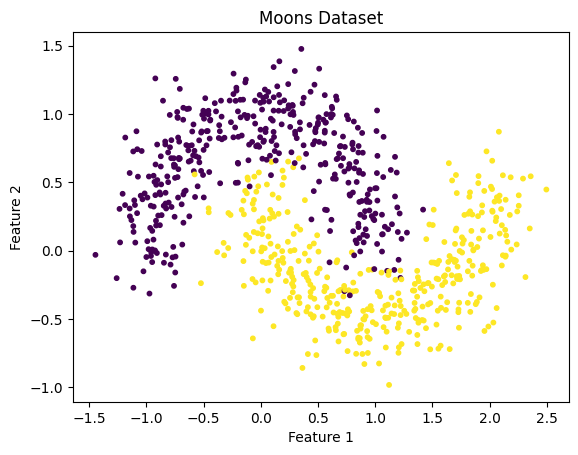

In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Moons Dataset')
plt.show()

**Classification task**: $P(y|\mathbf{x})$

**Generation task**: $P(\mathbf{x}|y)$

### Simple classification network

In [5]:
class MoonsClassifier(nn.Module):
    def __init__(self):
        super(MoonsClassifier, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [6]:
clf = MoonsClassifier()
clf.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=0.01)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = clf(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        outputs = clf(X_test_tensor)
        test_loss = criterion(outputs, y_test_tensor)
        outputs = (outputs > 0.5).float()
        accuracy = ((outputs == y_test_tensor).sum().item()) / y_test_tensor.size(0)

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [1], Loss: 0.6890, Test Loss: 0.6820, Accuracy: 0.5000
Epoch [2], Loss: 0.6802, Test Loss: 0.6742, Accuracy: 0.5000
Epoch [3], Loss: 0.6713, Test Loss: 0.6663, Accuracy: 0.5000
Epoch [4], Loss: 0.6622, Test Loss: 0.6578, Accuracy: 0.5000
Epoch [5], Loss: 0.6526, Test Loss: 0.6487, Accuracy: 0.5000
Epoch [6], Loss: 0.6423, Test Loss: 0.6389, Accuracy: 0.5000
Epoch [7], Loss: 0.6311, Test Loss: 0.6282, Accuracy: 0.5000
Epoch [8], Loss: 0.6193, Test Loss: 0.6167, Accuracy: 0.5650
Epoch [9], Loss: 0.6066, Test Loss: 0.6046, Accuracy: 0.7150
Epoch [10], Loss: 0.5933, Test Loss: 0.5918, Accuracy: 0.7550
Epoch [11], Loss: 0.5794, Test Loss: 0.5784, Accuracy: 0.7450
Epoch [12], Loss: 0.5648, Test Loss: 0.5643, Accuracy: 0.7600
Epoch [13], Loss: 0.5498, Test Loss: 0.5497, Accuracy: 0.7550
Epoch [14], Loss: 0.5343, Test Loss: 0.5345, Accuracy: 0.7600
Epoch [15], Loss: 0.5185, Test Loss: 0.5190, Accuracy: 0.7500
Epoch [16], Loss: 0.5025, Test Loss: 0.5032, Accuracy: 0.7750
Epoch [17], Loss:

Visualize the decision boundary:

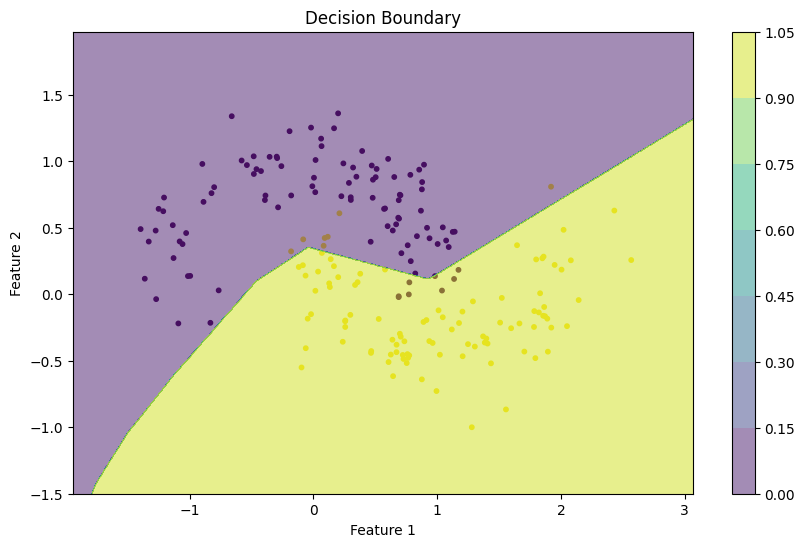

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10, cmap='viridis')
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005),
                     np.arange(y_min, y_max, 0.005))
with torch.no_grad():
    Z = clf(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.squeeze().numpy()
Z = (Z > 0.5).astype(int)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

### Simple generative network

Let's reverse the network:

In [8]:
class MoonsGenerator1(nn.Module):
    def __init__(self):
        super(MoonsGenerator1, self).__init__()
        self.fc1 = nn.Linear(1, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
gen = MoonsGenerator1()
gen.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = gen(y_train_tensor)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        outputs = gen(y_test_tensor)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 0.6291, Test Loss: 0.5851
Epoch [2], Loss: 0.5961, Test Loss: 0.5535
Epoch [3], Loss: 0.5665, Test Loss: 0.5256
Epoch [4], Loss: 0.5405, Test Loss: 0.5018
Epoch [5], Loss: 0.5186, Test Loss: 0.4827
Epoch [6], Loss: 0.5013, Test Loss: 0.4681
Epoch [7], Loss: 0.4884, Test Loss: 0.4578
Epoch [8], Loss: 0.4797, Test Loss: 0.4513
Epoch [9], Loss: 0.4744, Test Loss: 0.4469
Epoch [10], Loss: 0.4709, Test Loss: 0.4428
Epoch [11], Loss: 0.4673, Test Loss: 0.4375
Epoch [12], Loss: 0.4621, Test Loss: 0.4304
Epoch [13], Loss: 0.4546, Test Loss: 0.4217
Epoch [14], Loss: 0.4452, Test Loss: 0.4126
Epoch [15], Loss: 0.4350, Test Loss: 0.4027
Epoch [16], Loss: 0.4237, Test Loss: 0.3930
Epoch [17], Loss: 0.4124, Test Loss: 0.3837
Epoch [18], Loss: 0.4014, Test Loss: 0.3754
Epoch [19], Loss: 0.3912, Test Loss: 0.3680
Epoch [20], Loss: 0.3817, Test Loss: 0.3617
Epoch [21], Loss: 0.3735, Test Loss: 0.3564
Epoch [22], Loss: 0.3661, Test Loss: 0.3520
Epoch [23], Loss: 0.3596, Test Loss: 0.34

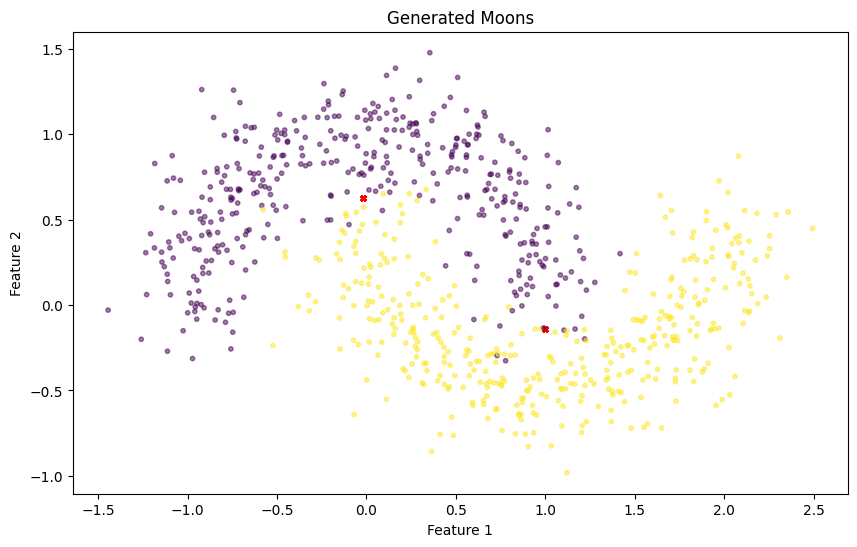

In [10]:
upper_moon_gen = gen(torch.FloatTensor([[1.0]] * 100))
lower_moon_gen = gen(torch.FloatTensor([[0.0]] * 100))
X_gen = torch.cat((upper_moon_gen, lower_moon_gen), dim=0).detach().numpy()
y_gen = np.concatenate((np.ones(100), np.zeros(100)), axis=0)
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Determenistic $\rightarrow$ single result

In [11]:
class MoonsGenerator2(nn.Module):
    def __init__(self):
        super(MoonsGenerator2, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
gen = MoonsGenerator2()
gen.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    train_noise = torch.randn(X_train_tensor.size(0), 1)
    y_train_tensor_ = torch.cat((y_train_tensor, train_noise), dim=1)
    outputs = gen(y_train_tensor_)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    clf.eval()
    with torch.no_grad():
        test_noise = torch.randn(X_test_tensor.size(0), 1)
        y_test_tensor_ = torch.cat((y_test_tensor, test_noise), dim=1)
        outputs = gen(y_test_tensor_)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 0.7782, Test Loss: 0.7379
Epoch [2], Loss: 0.7392, Test Loss: 0.6977
Epoch [3], Loss: 0.7036, Test Loss: 0.6671
Epoch [4], Loss: 0.6728, Test Loss: 0.6362
Epoch [5], Loss: 0.6451, Test Loss: 0.6102
Epoch [6], Loss: 0.6213, Test Loss: 0.5810
Epoch [7], Loss: 0.5990, Test Loss: 0.5661
Epoch [8], Loss: 0.5783, Test Loss: 0.5461
Epoch [9], Loss: 0.5610, Test Loss: 0.5299
Epoch [10], Loss: 0.5485, Test Loss: 0.5139
Epoch [11], Loss: 0.5376, Test Loss: 0.5029
Epoch [12], Loss: 0.5258, Test Loss: 0.4991
Epoch [13], Loss: 0.5151, Test Loss: 0.4867
Epoch [14], Loss: 0.5107, Test Loss: 0.4739
Epoch [15], Loss: 0.5032, Test Loss: 0.4688
Epoch [16], Loss: 0.4986, Test Loss: 0.4647
Epoch [17], Loss: 0.4864, Test Loss: 0.4581
Epoch [18], Loss: 0.4782, Test Loss: 0.4494
Epoch [19], Loss: 0.4698, Test Loss: 0.4332
Epoch [20], Loss: 0.4582, Test Loss: 0.4272
Epoch [21], Loss: 0.4479, Test Loss: 0.4154
Epoch [22], Loss: 0.4345, Test Loss: 0.4049
Epoch [23], Loss: 0.4239, Test Loss: 0.39

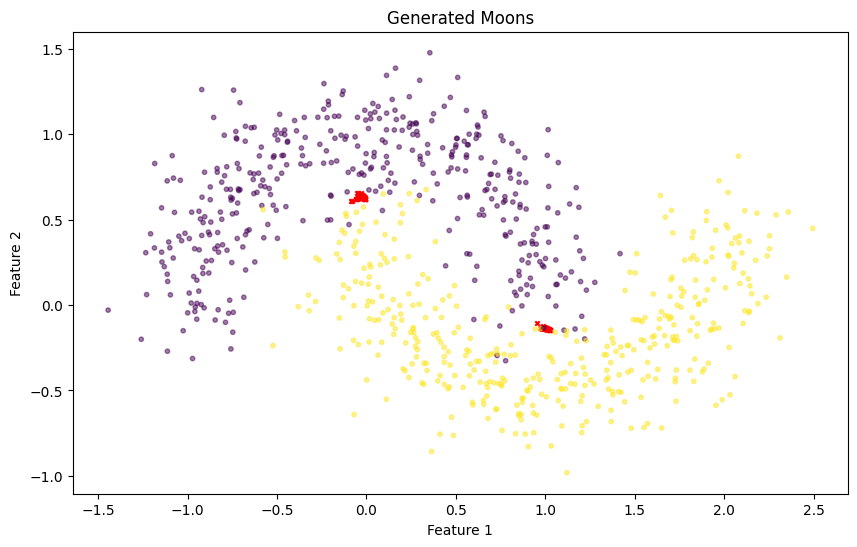

In [13]:
gen_input = torch.cat((torch.cat((torch.FloatTensor([[1.0]] * 100), torch.FloatTensor([[0.0]] * 100)), dim=0), torch.randn(200, 1)), dim=1)
with torch.no_grad():
    X_gen = gen(gen_input)
X_gen = X_gen.detach().numpy()
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Generative tasks in a nutshell

![](./assets/generative1.png)

Problem: complex shape manifold

![](./assets/generative2.png)

Solution: learn mapping to this manifold from the known

![](./assets/generative3.png)

### Common CV generative methods

![](./assets/cv_gen_methods.png)

## Autoencoder

In [94]:
class MoonAutoencoder(nn.Module):
    def __init__(self):
        super(MoonAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        latent = self.encoder(x)
        x_reconst = self.decoder(latent)
        return x_reconst
    
    def generate(self, latent):
        x_reconst = self.decoder(latent)
        return x_reconst

In [95]:
model = MoonAutoencoder()
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs = model(X_test_tensor)
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [1], Loss: 0.5923, Test Loss: 0.5570
Epoch [2], Loss: 0.5754, Test Loss: 0.5415
Epoch [3], Loss: 0.5613, Test Loss: 0.5289
Epoch [4], Loss: 0.5502, Test Loss: 0.5192
Epoch [5], Loss: 0.5420, Test Loss: 0.5125
Epoch [6], Loss: 0.5368, Test Loss: 0.5091
Epoch [7], Loss: 0.5349, Test Loss: 0.5089
Epoch [8], Loss: 0.5361, Test Loss: 0.5088
Epoch [9], Loss: 0.5369, Test Loss: 0.5075
Epoch [10], Loss: 0.5362, Test Loss: 0.5048
Epoch [11], Loss: 0.5336, Test Loss: 0.5009
Epoch [12], Loss: 0.5294, Test Loss: 0.4961
Epoch [13], Loss: 0.5240, Test Loss: 0.4907
Epoch [14], Loss: 0.5180, Test Loss: 0.4851
Epoch [15], Loss: 0.5115, Test Loss: 0.4792
Epoch [16], Loss: 0.5046, Test Loss: 0.4728
Epoch [17], Loss: 0.4971, Test Loss: 0.4656
Epoch [18], Loss: 0.4888, Test Loss: 0.4573
Epoch [19], Loss: 0.4792, Test Loss: 0.4475
Epoch [20], Loss: 0.4680, Test Loss: 0.4356
Epoch [21], Loss: 0.4547, Test Loss: 0.4212
Epoch [22], Loss: 0.4389, Test Loss: 0.4039
Epoch [23], Loss: 0.4198, Test Loss: 0.38

In [97]:
gen_input = torch.randn(100, 1) # torch.arange(-5, 5, 0.1).view(-1, 1)
with torch.no_grad():
    X_gen = model.generate(gen_input)
X_gen = X_gen.detach().numpy()

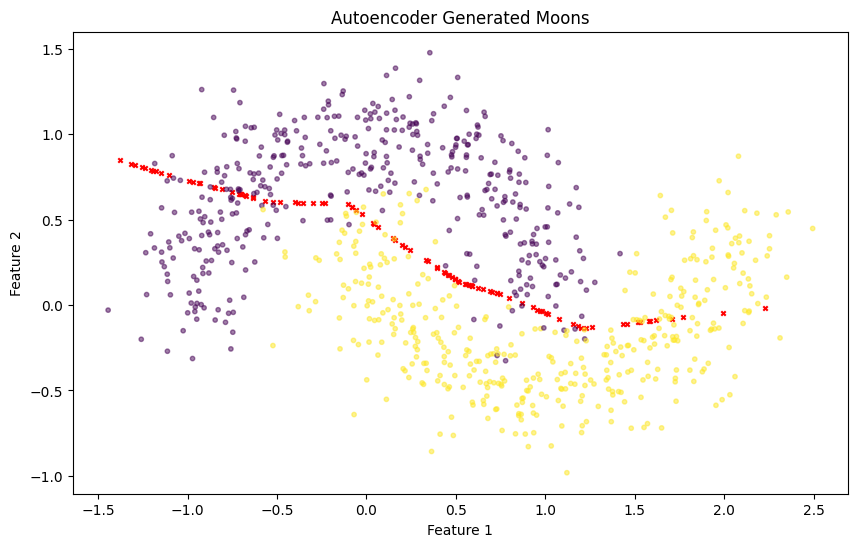

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Autoencoder Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [99]:
class MoonConditionalAutoencoder(nn.Module):
    def __init__(self):
        super(MoonConditionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.embedding = nn.Embedding(2, 1)

    def forward(self, x, y):
        latent = self.encoder(x)
        y = self.embedding(y)[:, 0]
        x_reconst = self.decoder(torch.cat((latent, y), dim=1))
        return x_reconst
    
    def generate(self, latent, y):
        y = self.embedding(y)[:, 0]
        x_reconst = self.decoder(torch.cat((latent, y), dim=1))
        return x_reconst

In [100]:
model = MoonConditionalAutoencoder()
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor, y_train_tensor.to(torch.long))
    loss = criterion(outputs, X_train_tensor)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs = model(X_test_tensor, y_test_tensor.to(torch.long))
        test_loss = criterion(outputs, X_test_tensor)
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [1], Loss: 1.1463, Test Loss: 1.0762
Epoch [2], Loss: 1.0745, Test Loss: 1.0070
Epoch [3], Loss: 1.0074, Test Loss: 0.9423
Epoch [4], Loss: 0.9449, Test Loss: 0.8820
Epoch [5], Loss: 0.8869, Test Loss: 0.8261
Epoch [6], Loss: 0.8332, Test Loss: 0.7742
Epoch [7], Loss: 0.7837, Test Loss: 0.7265
Epoch [8], Loss: 0.7381, Test Loss: 0.6841
Epoch [9], Loss: 0.6976, Test Loss: 0.6456
Epoch [10], Loss: 0.6609, Test Loss: 0.6103
Epoch [11], Loss: 0.6272, Test Loss: 0.5781
Epoch [12], Loss: 0.5964, Test Loss: 0.5488
Epoch [13], Loss: 0.5683, Test Loss: 0.5226
Epoch [14], Loss: 0.5430, Test Loss: 0.4995
Epoch [15], Loss: 0.5205, Test Loss: 0.4791
Epoch [16], Loss: 0.5009, Test Loss: 0.4610
Epoch [17], Loss: 0.4835, Test Loss: 0.4444
Epoch [18], Loss: 0.4673, Test Loss: 0.4286
Epoch [19], Loss: 0.4518, Test Loss: 0.4137
Epoch [20], Loss: 0.4366, Test Loss: 0.3995
Epoch [21], Loss: 0.4216, Test Loss: 0.3859
Epoch [22], Loss: 0.4069, Test Loss: 0.3722
Epoch [23], Loss: 0.3922, Test Loss: 0.35

In [ ]:
gen_input = torch.randn(200, 1) # torch.arange(-10, 10, 0.1).view(-1, 1)
y_gen = torch.cat((torch.LongTensor([[1]] * len(gen_input)), torch.LongTensor([[0]] * len(gen_input))), dim=0)
with torch.no_grad():
    X_gen = model.generate(gen_input.repeat(2, 1), y_gen)
X_gen = X_gen.detach().numpy()

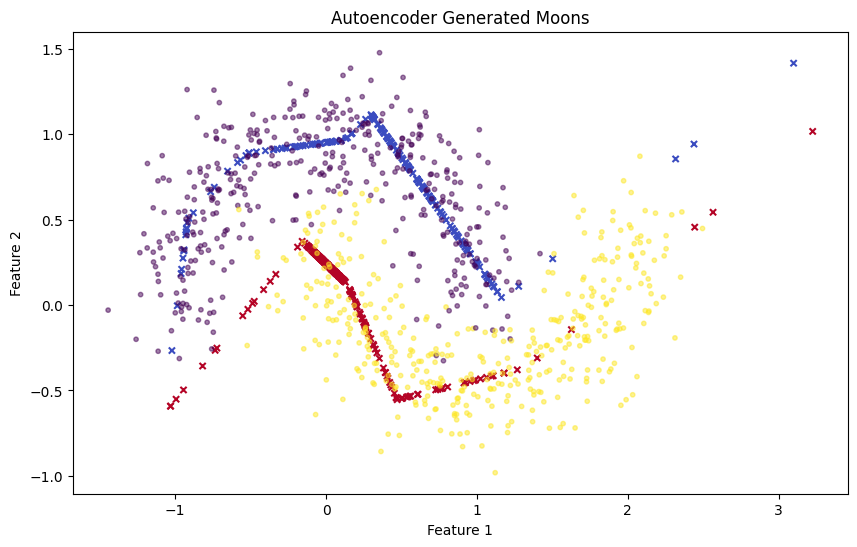

In [102]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=20, marker="x", cmap='coolwarm', c=y_gen)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Autoencoder Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Variational autoencoder (VAE)


In [22]:
class MoonVAE(nn.Module):
    def __init__(self):
        super(MoonVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc_out = self.encoder(x)
        mu = enc_out[:, 0].unsqueeze(1)
        logvar = enc_out[:, 1].unsqueeze(1)
        
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decoder(z)
        return x_reconst, mu, logvar
    
    def generate(self, z):
        x_reconst = self.decoder(z)
        return x_reconst

In [23]:
vae = MoonVAE()
vae.train()

reconstruction_criterion = nn.MSELoss()
kl_weight = 0.0001
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs, mu, logvar = vae(X_train_tensor)
    reconstruction_loss = reconstruction_criterion(outputs, X_train_tensor)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kl_weight * kl_loss
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs, mu, logvar = vae(X_test_tensor)
        test_reconstruction_loss = reconstruction_criterion(outputs, X_test_tensor)
        test_kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Reconstruction Loss: {test_reconstruction_loss.item():.4f}, Test KL Loss: {test_kl_loss.item():.4f}')

Epoch [1], Loss: 1.1025, Test Reconstruction Loss: 1.0629, Test KL Loss: 16.5114
Epoch [2], Loss: 1.0579, Test Reconstruction Loss: 1.0126, Test KL Loss: 13.7809
Epoch [3], Loss: 1.0123, Test Reconstruction Loss: 0.9870, Test KL Loss: 11.2602
Epoch [4], Loss: 0.9891, Test Reconstruction Loss: 0.9455, Test KL Loss: 8.9139
Epoch [5], Loss: 0.9538, Test Reconstruction Loss: 0.9177, Test KL Loss: 6.7088
Epoch [6], Loss: 0.9309, Test Reconstruction Loss: 0.8934, Test KL Loss: 4.6485
Epoch [7], Loss: 0.9022, Test Reconstruction Loss: 0.8736, Test KL Loss: 2.8738
Epoch [8], Loss: 0.8768, Test Reconstruction Loss: 0.8344, Test KL Loss: 1.4950
Epoch [9], Loss: 0.8426, Test Reconstruction Loss: 0.8112, Test KL Loss: 0.6137
Epoch [10], Loss: 0.8283, Test Reconstruction Loss: 0.7789, Test KL Loss: 0.3524
Epoch [11], Loss: 0.7963, Test Reconstruction Loss: 0.7491, Test KL Loss: 0.8824
Epoch [12], Loss: 0.7624, Test Reconstruction Loss: 0.7617, Test KL Loss: 2.4283
Epoch [13], Loss: 0.7431, Test Rec

In [24]:
gen_input = torch.randn(200, 1) # torch.arange(-10, 10, 0.1).view(-1, 1)
with torch.no_grad():
    X_gen = vae.generate(gen_input)
X_gen = X_gen.detach().numpy()

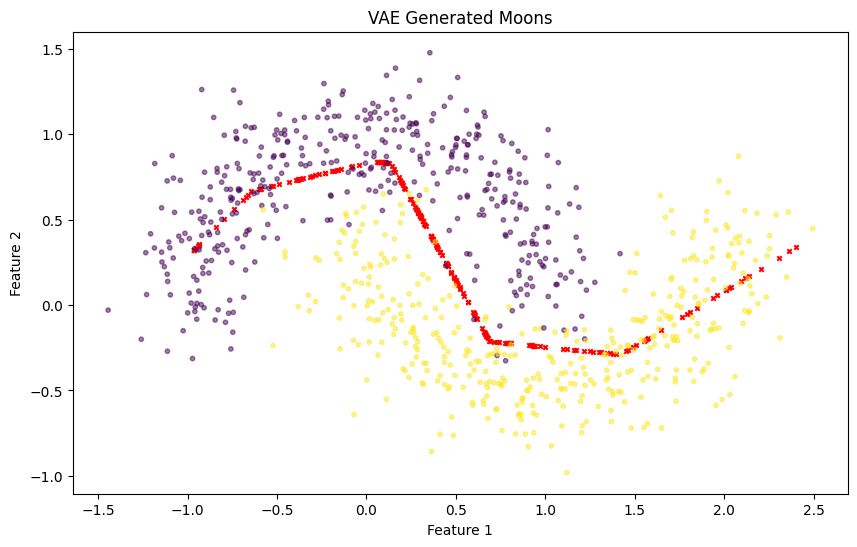

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('VAE Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [26]:
enc_out = vae.encoder(X_test_tensor)
mu = enc_out[:, 0].unsqueeze(1)
logvar = enc_out[:, 1].unsqueeze(1)

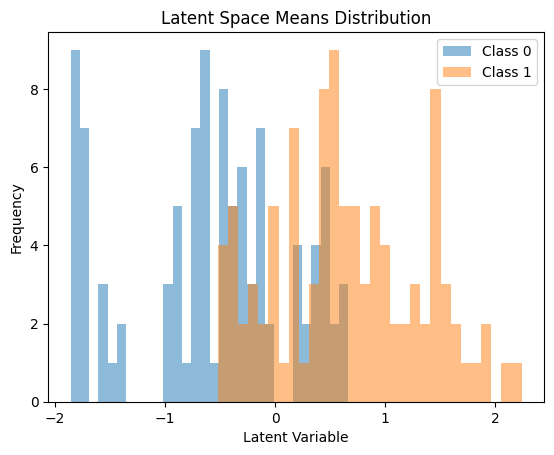

In [27]:
plt.hist(mu[y_test_tensor == 0].detach().numpy(), bins=30, alpha=0.5, label='Class 0')
plt.hist(mu[y_test_tensor == 1].detach().numpy(), bins=30, alpha=0.5, label='Class 1')
plt.title('Latent Space Means Distribution')
plt.xlabel('Latent Variable')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [28]:
class MoonVAEConditional(nn.Module):
    def __init__(self):
        super(MoonVAEConditional, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.embedding = nn.Embedding(2, 1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        enc_out = self.encoder(x)
        mu = enc_out[:, 0].unsqueeze(1)
        logvar = enc_out[:, 1].unsqueeze(1)
        
        z = self.reparameterize(mu, logvar)
        y = self.embedding(y)[:, 0]
        z = torch.cat((z, y), dim=1)

        x_reconst = self.decoder(z)
        return x_reconst, mu, logvar
    
    def generate(self, z, y):
        y = self.embedding(y)[:, 0]
        z = torch.cat((z, y), dim=1)
        x_reconst = self.decoder(z)
        return x_reconst

In [29]:
vae = MoonVAEConditional()
vae.train()

reconstruction_criterion = nn.MSELoss()
kl_weight = 0.0001
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs, mu, logvar = vae(X_train_tensor, y_train_tensor.to(torch.long))
    reconstruction_loss = reconstruction_criterion(outputs, X_train_tensor)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kl_weight * kl_loss
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        outputs, mu, logvar = vae(X_test_tensor, y_test_tensor.to(torch.long))
        test_reconstruction_loss = reconstruction_criterion(outputs, X_test_tensor)
        test_kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Reconstruction Loss: {test_reconstruction_loss.item():.4f}, Test KL Loss: {test_kl_loss.item():.4f}')

Epoch [1], Loss: 0.9983, Test Reconstruction Loss: 0.9460, Test KL Loss: 8.0574
Epoch [2], Loss: 0.9517, Test Reconstruction Loss: 0.8998, Test KL Loss: 7.1524
Epoch [3], Loss: 0.9068, Test Reconstruction Loss: 0.8574, Test KL Loss: 6.4959
Epoch [4], Loss: 0.8671, Test Reconstruction Loss: 0.8227, Test KL Loss: 6.0226
Epoch [5], Loss: 0.8311, Test Reconstruction Loss: 0.7837, Test KL Loss: 5.6886
Epoch [6], Loss: 0.7962, Test Reconstruction Loss: 0.7499, Test KL Loss: 5.4952
Epoch [7], Loss: 0.7623, Test Reconstruction Loss: 0.7181, Test KL Loss: 5.4188
Epoch [8], Loss: 0.7332, Test Reconstruction Loss: 0.6899, Test KL Loss: 5.3890
Epoch [9], Loss: 0.7047, Test Reconstruction Loss: 0.6600, Test KL Loss: 5.3408
Epoch [10], Loss: 0.6781, Test Reconstruction Loss: 0.6350, Test KL Loss: 5.2089
Epoch [11], Loss: 0.6531, Test Reconstruction Loss: 0.6082, Test KL Loss: 4.9775
Epoch [12], Loss: 0.6287, Test Reconstruction Loss: 0.5855, Test KL Loss: 4.6294
Epoch [13], Loss: 0.6079, Test Recons

In [30]:
gen_input = torch.randn(200, 1) # torch.arange(-20, 20, 0.1).view(-1, 1) # torch.randn(200, 1)
y_gen = torch.cat((torch.LongTensor([[1]] * len(gen_input)), torch.LongTensor([[0]] * len(gen_input))), dim=0)
with torch.no_grad():
    X_gen = vae.generate(gen_input.repeat(2, 1), y_gen)
X_gen = X_gen.detach().numpy()

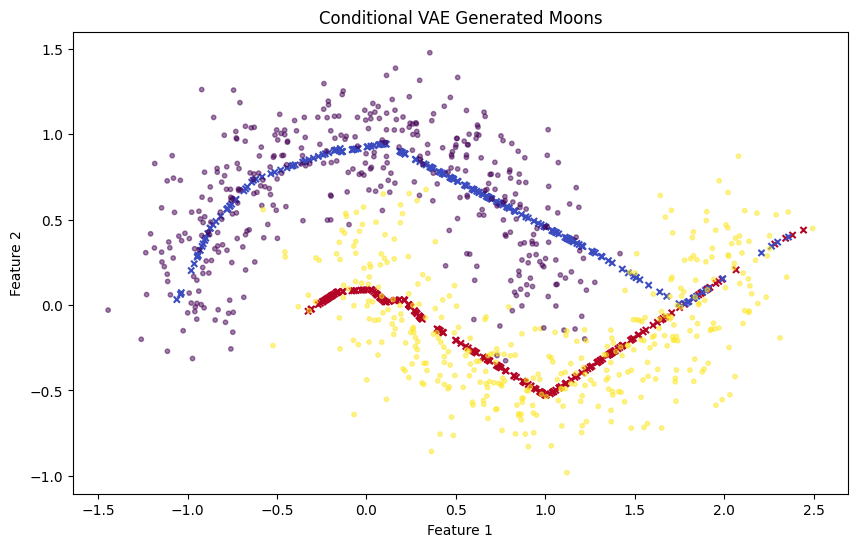

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=20, marker="x", c=y_gen, cmap='coolwarm')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Conditional VAE Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Diffusion

![](./assets/diffusion.png)

Diffusion can be formalized as a fixed Markov chain with T steps. Each step depends only on the previous one, allowing us to derive a closed-form formula to obtain the corrupted image at any desired timestep, bypassing the need for iterative computation.

Schedulers:

![](./assets/schedulers.png)



In [80]:
class MoonsUNet(nn.Module):
    def __init__(self, num_timesteps=100, time_emb_dim=2):
        super(MoonsUNet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Linear(2 + time_emb_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.encoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8 + time_emb_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
        )
        self.bottleneck = nn.Sequential(
            nn.ReLU(),
            nn.Linear(4 + time_emb_dim, 2),
            nn.ReLU(),
            nn.Linear(2, 4),
        )
        self.decoder1 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.decoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )
        self.num_timesteps = num_timesteps
        self.time_embedding = nn.Embedding(num_timesteps, time_emb_dim)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)[:, 0]
        x = torch.cat((x, t_emb), dim=1)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(torch.cat((enc1, t_emb), dim=1))
        bottleneck = self.bottleneck(torch.cat((enc2, t_emb), dim=1))
        dec1 = self.decoder1(torch.cat((bottleneck, enc2), dim=1))
        dec2 = self.decoder2(torch.cat((dec1, enc1), dim=1))
        return dec2

In [81]:
num_epochs = 1000
num_timesteps = 100

unet = MoonsUNet(num_timesteps=num_timesteps, time_emb_dim=2)
unet.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)

In [ ]:
def linear_schedule(t, timesteps, beta1=1e-4, beta2=0.02):
    return (beta2 - beta1) * t / timesteps + beta1

def cosine_schedule(t, timesteps, s=0.008):
    alpha_hat = np.cos(np.pi/2*(t / timesteps + s)/(1 + s))**2
    alpha_hat_prev = np.cos(np.pi/2*((t-1) / timesteps + s)/(1 + s))**2
    beta = 1 - alpha_hat/alpha_hat_prev
    beta = torch.clip(beta, None, 0.999)
    return beta

linear_betas = linear_schedule(torch.arange(num_timesteps), num_timesteps)
cosine_betas = cosine_schedule(torch.arange(num_timesteps), num_timesteps)

linear_alphas = 1 - linear_betas
cosine_alphas = 1 - cosine_betas

linear_alphas_cumprod = torch.cumprod(linear_alphas, dim=0)
cosine_alphas_cumprod = torch.cumprod(cosine_alphas, dim=0)
linear_alphas_cumprod_prev = torch.cat((torch.tensor([1.0]), linear_alphas_cumprod[:-1]), dim=0)
cosine_alphas_cumprod_prev = torch.cat((torch.tensor([1.0]), cosine_alphas_cumprod[:-1]), dim=0)

def apply_diffusion(X, t, schedule):
    noise = torch.randn_like(X)
    if schedule == "Linear":
        alpha_hat = linear_alphas_cumprod[t]
    elif schedule == "Cosine":
        alpha_hat = cosine_alphas_cumprod[t]

    return alpha_hat.sqrt() * X + (1 - alpha_hat).sqrt() * noise, noise

def update_plot(*args):
    with output:
        output.clear_output(wait=True)
        
        schedule = dropdown_schedule.value
        X_noisy, _ = apply_diffusion(X_train_tensor, slider_timesteps.value, schedule)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(X_noisy[:, 0], X_noisy[:, 1], c=y_train, s=10, cmap='viridis')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title('Moons Dataset with Diffusion')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-1.5, 1.5)
        
        display(fig)
        plt.close(fig)

slider_timesteps = widgets.IntSlider(min=1, max=num_timesteps, step=1, value=1, description="Timesteps")
dropdown_schedule = widgets.Dropdown(options=["Linear", "Cosine"], value="Linear", description="Schedule")
output = widgets.Output()

slider_timesteps.observe(update_plot, names='value')
dropdown_schedule.observe(update_plot, names='value')

display(slider_timesteps, dropdown_schedule, output)
update_plot()

IntSlider(value=1, description='Timesteps', min=1)

Dropdown(description='Schedule', options=('Linear', 'Cosine'), value='Linear')

Output()

In [89]:
chosen_schedule = "Linear"

for epoch in range(num_epochs):
    unet.train()
    timesteps = torch.randint(0, num_timesteps, (X_train_tensor.size(0), 1))

    optimizer.zero_grad()
    noisy_X, noise = apply_diffusion(X_train_tensor, timesteps, chosen_schedule)
    noisy_X = noisy_X.float()
    outputs = unet(noisy_X, timesteps)
    loss = criterion(outputs, noise)
    
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        unet.eval()
        timesteps = torch.randint(0, num_timesteps, (X_test_tensor.size(0), 1))
        noisy_X, noise = apply_diffusion(X_test_tensor, timesteps, chosen_schedule)
        outputs = unet(noisy_X, timesteps)
        test_loss = criterion(outputs, noise)

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 0.7134, Test Loss: 0.6213
Epoch [2], Loss: 0.6547, Test Loss: 0.5922
Epoch [3], Loss: 0.6394, Test Loss: 0.6696
Epoch [4], Loss: 0.6135, Test Loss: 0.5577
Epoch [5], Loss: 0.6160, Test Loss: 0.5906
Epoch [6], Loss: 0.6500, Test Loss: 0.7229
Epoch [7], Loss: 0.6961, Test Loss: 0.6030
Epoch [8], Loss: 0.6377, Test Loss: 0.6208
Epoch [9], Loss: 0.6165, Test Loss: 0.6139
Epoch [10], Loss: 0.6498, Test Loss: 0.6396
Epoch [11], Loss: 0.5751, Test Loss: 0.7081
Epoch [12], Loss: 0.6317, Test Loss: 0.6316
Epoch [13], Loss: 0.6502, Test Loss: 0.5038
Epoch [14], Loss: 0.6146, Test Loss: 0.6811
Epoch [15], Loss: 0.5722, Test Loss: 0.6339
Epoch [16], Loss: 0.6344, Test Loss: 0.6755
Epoch [17], Loss: 0.6314, Test Loss: 0.5743
Epoch [18], Loss: 0.6105, Test Loss: 0.6137
Epoch [19], Loss: 0.5856, Test Loss: 0.6474
Epoch [20], Loss: 0.6090, Test Loss: 0.5274
Epoch [21], Loss: 0.6324, Test Loss: 0.5700
Epoch [22], Loss: 0.6166, Test Loss: 0.5646
Epoch [23], Loss: 0.6222, Test Loss: 0.52

DDPM scheduling:

In [ ]:
samples = 1000

X_gen = torch.randn(samples, 2)
X_gen_samples = []
for t in reversed(range(num_timesteps)):
    t_tensor = torch.full((samples, 1), t)
    pred_noise = unet(X_gen, t_tensor)
    noise = torch.randn_like(X_gen)

    beta_t = linear_betas[t] if chosen_schedule == "Linear" else cosine_betas[t]
    alpha_hat_t = linear_alphas_cumprod[t] if chosen_schedule == "Linear" else cosine_alphas_cumprod[t]
    
    if t > 0:
        X_gen = (X_gen - pred_noise * beta_t / (1 - alpha_hat_t).sqrt()) + noise * beta_t.sqrt()
    else:
        X_gen = (X_gen - pred_noise * beta_t / (1 - alpha_hat_t).sqrt())
    X_gen_samples.append(X_gen.detach().numpy())
    
X_gen = X_gen.detach().numpy()

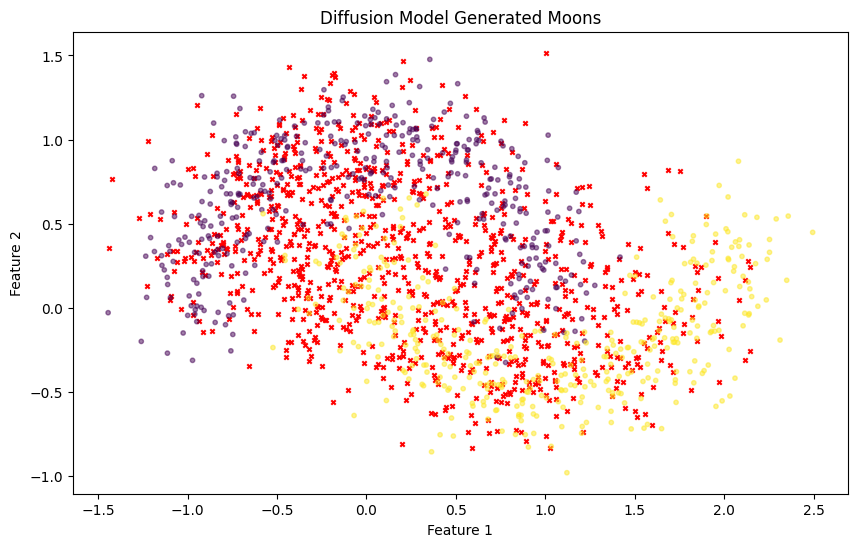

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", c='red')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Diffusion Model Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [112]:
def update_plot(*args):
    with output:
        output.clear_output(wait=True)
        
        X_gen_chosen = X_gen_samples[num_timesteps - slider_timesteps.value]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(X_gen_chosen[:, 0], X_gen_chosen[:, 1], s=10, marker="x", c='red')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_title(f'Generated Moons at timestep {slider_timesteps.value}')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-1.5, 1.5)
        
        display(fig)
        plt.close(fig)

slider_timesteps = widgets.IntSlider(min=0, max=num_timesteps, step=1, value=num_timesteps, description="Timesteps")
output = widgets.Output()

slider_timesteps.observe(update_plot, names='value')

display(slider_timesteps, output)
update_plot()

IntSlider(value=100, description='Timesteps')

Output()

> **TODO**: Read about DDIM sampling.

In [114]:
class MoonsUNetConditional(nn.Module):
    def __init__(self, num_timesteps=100, time_emb_dim=2, class_emb_dim=2):
        super(MoonsUNetConditional, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Linear(2 + time_emb_dim + class_emb_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.encoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8 + time_emb_dim + class_emb_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
        )
        self.bottleneck = nn.Sequential(
            nn.ReLU(),
            nn.Linear(4 + time_emb_dim + class_emb_dim, 2),
            nn.ReLU(),
            nn.Linear(2, 4),
        )
        self.decoder1 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
        )
        self.decoder2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )
        self.num_timesteps = num_timesteps
        self.time_embedding = nn.Embedding(num_timesteps, time_emb_dim)
        self.class_embedding = nn.Embedding(2, class_emb_dim)

    def forward(self, x, y, t):
        t_emb = self.time_embedding(t)[:, 0]
        y_emb = self.class_embedding(y)[:, 0]
        x = torch.cat((x, y_emb, t_emb), dim=1)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(torch.cat((enc1, y_emb, t_emb), dim=1))
        bottleneck = self.bottleneck(torch.cat((enc2, y_emb, t_emb), dim=1))
        dec1 = self.decoder1(torch.cat((bottleneck, enc2), dim=1))
        dec2 = self.decoder2(torch.cat((dec1, enc1), dim=1))
        return dec2

In [115]:
num_epochs = 1000
num_timesteps = 100

unet = MoonsUNetConditional(num_timesteps=num_timesteps, time_emb_dim=2, class_emb_dim=2)
unet.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)

In [117]:
chosen_schedule = "Linear"

for epoch in range(num_epochs):
    unet.train()
    timesteps = torch.randint(0, num_timesteps, (X_train_tensor.size(0), 1))

    optimizer.zero_grad()
    noisy_X, noise = apply_diffusion(X_train_tensor, timesteps, chosen_schedule)
    noisy_X = noisy_X.float()
    outputs = unet(noisy_X, y_train_tensor.long(), timesteps)
    loss = criterion(outputs, noise)
    
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        unet.eval()
        timesteps = torch.randint(0, num_timesteps, (X_test_tensor.size(0), 1))
        noisy_X, noise = apply_diffusion(X_test_tensor, timesteps, chosen_schedule)
        outputs = unet(noisy_X, y_test_tensor.long(), timesteps)
        test_loss = criterion(outputs, noise)

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1], Loss: 1.0893, Test Loss: 1.0128
Epoch [2], Loss: 0.9849, Test Loss: 1.0713
Epoch [3], Loss: 1.0503, Test Loss: 1.1003
Epoch [4], Loss: 0.9611, Test Loss: 0.9192
Epoch [5], Loss: 1.0067, Test Loss: 1.0440
Epoch [6], Loss: 1.0154, Test Loss: 0.8877
Epoch [7], Loss: 1.0329, Test Loss: 1.0219
Epoch [8], Loss: 0.9685, Test Loss: 1.0223
Epoch [9], Loss: 0.9435, Test Loss: 0.9455
Epoch [10], Loss: 0.9830, Test Loss: 1.0761
Epoch [11], Loss: 0.9447, Test Loss: 1.0186
Epoch [12], Loss: 0.9541, Test Loss: 0.8590
Epoch [13], Loss: 0.9147, Test Loss: 0.8236
Epoch [14], Loss: 0.9184, Test Loss: 0.9201
Epoch [15], Loss: 0.9497, Test Loss: 0.9378
Epoch [16], Loss: 0.9326, Test Loss: 0.8107
Epoch [17], Loss: 0.9165, Test Loss: 0.8897
Epoch [18], Loss: 0.8868, Test Loss: 0.9822
Epoch [19], Loss: 0.8659, Test Loss: 0.7776
Epoch [20], Loss: 0.7699, Test Loss: 0.8005
Epoch [21], Loss: 0.8306, Test Loss: 0.8467
Epoch [22], Loss: 0.8195, Test Loss: 0.8372
Epoch [23], Loss: 0.7734, Test Loss: 0.78

In [118]:
samples = 1000

X_gen = torch.randn(samples, 2)
y_gen = torch.randint(0, 2, (samples, 1))
X_gen_samples = []
for t in reversed(range(num_timesteps)):
    t_tensor = torch.full((samples, 1), t)
    pred_noise = unet(X_gen, y_gen, t_tensor)
    noise = torch.randn_like(X_gen)

    beta_t = linear_betas[t] if chosen_schedule == "Linear" else cosine_betas[t]
    alpha_hat_t = linear_alphas_cumprod[t] if chosen_schedule == "Linear" else cosine_alphas_cumprod[t]
    
    if t > 0:
        X_gen = (X_gen - pred_noise * beta_t / (1 - alpha_hat_t).sqrt()) + noise * beta_t.sqrt()
    else:
        X_gen = (X_gen - pred_noise * beta_t / (1 - alpha_hat_t).sqrt())
    X_gen_samples.append(X_gen.detach().numpy())
    
X_gen = X_gen.detach().numpy()

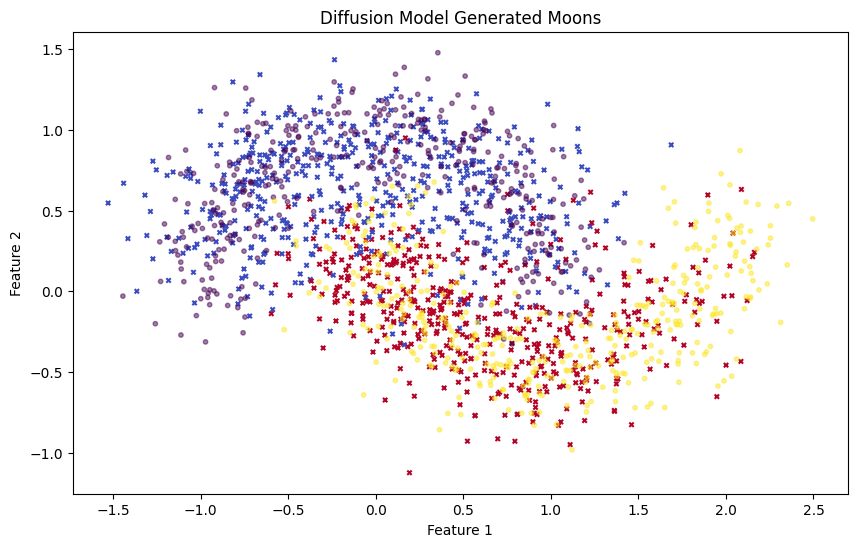

In [119]:
plt.figure(figsize=(10, 6))
plt.scatter(X_gen[:, 0], X_gen[:, 1], s=10, marker="x", cmap='coolwarm', c=y_gen)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=10, alpha=0.5)
plt.title('Diffusion Model Generated Moons')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

> **TODO**: Read about and implement a classifier-free guidance technique.

## NLP

![](./assets/chatgpt.jpg)

### Dataset

Source: https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [120]:
DATA_PATH = './shakespeare.txt'
with open(DATA_PATH, 'r') as f:
    text = f.read()

In [121]:
text

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [126]:
print(f"Length of text: {len(text)} characters")
print(f"\t\t~{len(text.split())} words")
print(f"Number of unique characters: {len(set(text))}")
print(f"Number of unique words: ~{len(set(text.split()))}")


Length of text: 1115394 characters
		~202651 words
Number of unique characters: 65
Number of unique words: ~25670


### Preparation

![](./assets/tokenization.jpg)

> **TODO**: read about byte-pair encoding (BPE) algorithm for tokens selection.

In [164]:
train_frac = 0.9

train_text = text[:int(len(text) * train_frac)]
val_text = text[int(len(text) * train_frac):-1]

In [ ]:
tokens = set(train_text)
tokens = sorted(list(tokens))
tokens = ['<sos>', '<unk>'] + tokens
print(f"Vocabulary size: {len(tokens)}")

token2id = {token: i for i, token in enumerate(tokens)}
id2token = {i: token for i, token in enumerate(tokens)}

Vocabulary size: 67


In [146]:
train_ids = [token2id[token] for token in train_text]
val_ids = [token2id[token] for token in val_text]

In [147]:
print(train_ids[:10])
print(train_text[:10])

[20, 49, 58, 59, 60, 3, 17, 49, 60, 49]
First Citi


### Modelling

![](./assets/autoregression.png)

In [ ]:
seq_len = 128

In [166]:
train_sequences = [[token2id['<sos>'] for _ in range(seq_len - end)] + train_ids[:end] for end in range(1, seq_len)] + [train_ids[start:start + seq_len] for start in range(len(train_ids) - seq_len)]
val_sequences = [[token2id['<sos>'] for _ in range(seq_len - end)] + val_ids[:end] for end in range(1, seq_len)] + [val_ids[start:start + seq_len] for start in range(len(val_ids) - seq_len)]

train_targets = text[1:int(len(text) * train_frac)+1]
train_targets = [token2id[token] for token in train_targets]

val_targets = text[int(len(text) * train_frac)+1:]
val_targets = [token2id[token] for token in val_targets]

train_sequences = torch.tensor(train_sequences)
val_sequences = torch.tensor(val_sequences)
train_targets = torch.tensor(train_targets)
val_targets = torch.tensor(val_targets)

In [143]:
class LSTMAutoregression(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=3):
        super(LSTMAutoregression, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x, None)
        # x is (batch_size, seq_len, hidden_dim)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [ ]:
lstm_model = LSTMAutoregression(vocab_size=len(tokens), embedding_dim=32, hidden_dim=128)
lstm_model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
batch_size = 32

In [ ]:
len(train_sequences[0]), len(train_sequences[1024])

(128, 128)

In [170]:
print(train_ids[:10])
print(train_targets[:10])

[20, 49, 58, 59, 60, 3, 17, 49, 60, 49]
tensor([49, 58, 59, 60,  3, 17, 49, 60, 49, 66])


In [174]:
train_steps = 10_000
eval_every = 100
train_losses = []
val_losses = []

for step in range(train_steps):
    lstm_model.train()
    optimizer.zero_grad()

    batch_indices = torch.randint(0, len(train_sequences), (batch_size,))
    batch_inputs = train_sequences[batch_indices]
    batch_targets = train_targets[batch_indices]

    outputs = lstm_model(batch_inputs)
    loss = criterion(outputs, batch_targets)
    loss.backward()
    optimizer.step()

    if step % eval_every == 0:
        train_losses.append(loss.item())
        lstm_model.eval()
        with torch.no_grad():
            val_outputs = lstm_model(val_sequences[:100])
            val_loss = criterion(val_outputs, val_targets[:100]).item()
            val_losses.append(val_loss)
            print(f"Step {step}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

Step 0, Train Loss: 3.5742, Val Loss: 3.7690
Step 100, Train Loss: 3.0291, Val Loss: 3.7055
Step 200, Train Loss: 3.5601, Val Loss: 3.4923
Step 300, Train Loss: 2.8717, Val Loss: 3.2198
Step 400, Train Loss: 3.1089, Val Loss: 3.0054
Step 500, Train Loss: 2.3084, Val Loss: 3.0188
Step 600, Train Loss: 2.8983, Val Loss: 2.9893
Step 700, Train Loss: 2.7561, Val Loss: 2.9249
Step 800, Train Loss: 2.6102, Val Loss: 2.8404
Step 900, Train Loss: 2.7812, Val Loss: 2.7787
Step 1000, Train Loss: 2.3320, Val Loss: 2.9275
Step 1100, Train Loss: 2.3835, Val Loss: 2.7974
Step 1200, Train Loss: 2.4512, Val Loss: 2.7547
Step 1300, Train Loss: 2.2209, Val Loss: 2.7419
Step 1400, Train Loss: 1.9816, Val Loss: 2.7257
Step 1500, Train Loss: 2.2093, Val Loss: 2.7414
Step 1600, Train Loss: 2.5598, Val Loss: 2.7361
Step 1700, Train Loss: 2.1197, Val Loss: 2.7332
Step 1800, Train Loss: 2.0386, Val Loss: 2.6482
Step 1900, Train Loss: 2.6775, Val Loss: 2.6362
Step 2000, Train Loss: 1.9961, Val Loss: 2.6403
Step

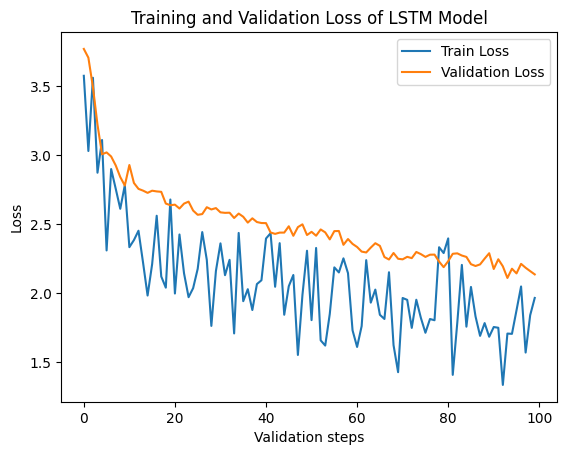

In [175]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Validation steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of LSTM Model')
plt.show()

#### Greedy search sampling

In [ ]:
lstm_model.eval()

desired_len = 100

cur_sequence = [token2id['<sos>']]
for _ in range(desired_len):
    input_tensor = torch.tensor(cur_sequence).unsqueeze(0)
    with torch.no_grad():
        output = lstm_model(input_tensor)
        predicted_token = torch.argmax(output, dim=1).item()
        cur_sequence.append(predicted_token)
    print(id2token[cur_sequence[-1]], end='')
    sleep(0.1)


rned the stand of the stand of the stand of the stand of the stand of the stand of the stand of the 

#### Random sampling

In [179]:
lstm_model.eval()

desired_len = 100

cur_sequence = [token2id['<sos>']]
for _ in range(desired_len):
    input_tensor = torch.tensor(cur_sequence).unsqueeze(0)
    with torch.no_grad():
        output = lstm_model(input_tensor)
        probability_distribution = torch.softmax(output, dim=1)
        predicted_token = torch.multinomial(probability_distribution, 1).item()
        cur_sequence.append(predicted_token)
    print(id2token[cur_sequence[-1]], end='')
    sleep(0.1)


rrns afdarish that on boks to-stasefu: fove, a'd we encay, not the
not, in thour momorod of Docton;


#### Top k sampling

In [188]:
lstm_model.eval()

desired_len = 100
top_k = 5

cur_sequence = [token2id['<sos>']]
for _ in range(desired_len):
    input_tensor = torch.tensor(cur_sequence).unsqueeze(0)
    with torch.no_grad():
        output = lstm_model(input_tensor)
        probability_distribution = torch.softmax(output, dim=1)
        # top k sampling
        top_k_samples = torch.topk(probability_distribution, top_k).indices[0]
        top_k_probs = torch.topk(probability_distribution, top_k).values[0]
        top_k_probs = top_k_probs / torch.sum(top_k_probs)

        predicted_token = top_k_samples[torch.multinomial(top_k_probs, 1)].item()
        cur_sequence.append(predicted_token)
    print(id2token[cur_sequence[-1]], end='')
    sleep(0.1)


int hone.

SICINIUS:
Helland treat that so and word he the wand this streak his.

PLOUCESTER:
Al as 

> **TODO**: Implement top p sampling and beam search.

## Evaluating generative models

### Frechet distance

Lower (better) if generated and real distributions are similar.

$d^2 = |\mu_X - \mu_Y|^2 + \text{tr}(\Sigma_X + \Sigma_Y - 2(\Sigma_X\Sigma_Y)^{0.5})$

![](./assets/FID.png)

FAD - Frechet Audio Distance

### Inception score

Higher (better) if:
- Images vary;
- Images correspond to model classes.

![](./assets/inception_score.webp)

$\text{IS} = e^{\mathbb{E}_{\mathbf{x}}\text{D}_{\text{KL}}(p(y|\mathbf{x})\|p(y)))}$

$\text{D}_{\text{KL}}(P\|Q) = -\sum_{x\in X}P(x)\log{\frac{Q(x)}{P(x)}}$

![](./assets/kl.webp)

### CLIP score

![](./assets/clip.svg)